Time Calibration of the Mu2e Calorimeter

by Giacinto boccia

version 2.0 | 2024-09-27

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as sp
import awkward as ak
import uproot
import quantities as pq
from concurrent.futures import ProcessPoolExecutor, ThreadPoolExecutor
import warnings

In [2]:
#Cut parameters
YSPAN_CUT =         200 * pq.mm
HITNUM_CUT =        3           #6
V_MIN_CUT =         300         #Use 338 for 15 MeV 
V_MAX_CUT =         800         #Use 675 for 30 MeV
COS_THETA_CUT =     0.2         #0.2 Theta refers to Y axis
CHI_ON_NDF_CUT =    5           #2
VERTICALS =         False       #Allows verticl events
RES_NUM_CUT =       10          #Minimum number of residuals to calibrate a channel
MIN_RES_CUT =       -10 *pq.ns  #Decides the rejection criterium for residuals of each channel
MAX_RES_CUT =       10  *pq.ns
#Other constants
IGNORE_TVAL =       False       #For tests only, considers emplateTime and not Tval
CORR_FACTOR =       1           #Speed at wich the calibration correction changes
N_ROWS =            36
N_COLUMNS =         28
N_SIPMS =           2
CRY_SIDE =          34.4 * pq.mm
GRAPH_RUNS_STEP =   2           #Plots will show runs following this stepping (say run 0, 3, 6, 9)       


In [3]:
class Cosmic_Event_Class(ak.Record):
    
    def v_filter(self) -> list[bool]:
        v_min_fitler = self.Vmax > V_MIN_CUT
        v_max_fitler = self.Vmax < V_MAX_CUT
        v_filter = v_max_fitler & v_min_fitler
        return v_filter
       
    def t_residuals(self) -> dict[str, np.double] | None:
        #returns a dictionary with 'row, col, sipm' as key and the residual as value
        v_filter = self.v_filter()
        
        #Get the input values from the event
        if self.slope:
            #Vertical events hace a "None" slope
            #Note that theta here is referred to the Y axis
            cos_theta = self.slope / np.sqrt(1 + self.slope ** 2)
        elif self.vertical and VERTICALS:
            cos_theta = 1
        else:
            #This is if we are skipping vertial events
            return None
        with warnings.catch_warnings(action="ignore"):
            #Suppress warnings from the coflict between np and ak
            if IGNORE_TVAL:
                t_arr = np.array(self.templTime[v_filter]) * pq.ns
            else:
                t_arr = np.array(self.Tval[v_filter] + self.templTime[v_filter]) * pq.ns 
            y_arr = np.array(self.Yval[v_filter]) * pq.mm
            v_arr = np.array(self.Vmax[v_filter])
        t_res = dict()
        #This will hold the times corrected for the position of the hit
        t_geom_arr = np.full_like(t_arr, np.nan)
        
        #Compute the residuals and return
        for i, [row, col, sipm] in enumerate(zip(self.iRow[v_filter],
                                                 self.iCol[v_filter],
                                                 self.SiPM[v_filter])):
            #Apply current time corrections and compute space-corrected residuals
            t_arr[i] += cal_corection[row, col, sipm]
            t_geom_arr[i] = t_arr[i] + y_arr[i] / (pq.c * cos_theta)
        #Here t0 is more like the average residual than the average time       
        t0_ev = np.average(t_geom_arr, weights= v_arr)
        for t_geom, row, col, sipm in zip(t_geom_arr,
                                          self.iRow[v_filter],
                                          self.iCol[v_filter],
                                          self.SiPM[v_filter]):
            #Each residual is stored in the dictionary with '(row, col, sipm)' as key
            residual = t_geom - t0_ev
            residual.units = pq.ns
            t_res[str(row) + ', ' + str(col) + ', ' + str(sipm)] = residual.item()
        return t_res
    
    def y_span(self) -> pq.Quantity:
        #Returns the y span of the event, in mm
        v_filter = self.v_filter()
        if len(self.Yval[v_filter]) > 0:
            y_max = np.max(self.Yval[v_filter])
            y_min = np.min(self.Yval[v_filter])
            return (y_max - y_min) * pq.mm
        else:
            return np.nan * pq.mm        
ak.behavior["cosmic"] = Cosmic_Event_Class

def linear_fit(event : Cosmic_Event_Class) -> dict[str, np.double | int]:
    v_filter = event.v_filter()
    x_arr = event.Xval[v_filter] * pq.mm
    y_arr = event.Yval[v_filter] * pq.mm
    if len(x_arr) > 1:
        #Events that are not empty
        if np.max(x_arr) - np.min(x_arr) > CRY_SIDE:
            #Events that are not vertical
            [slope, intercept], residuals, _, _, _ = np.polyfit(x_arr, y_arr, deg= 1, full= True)
            chi_sq : np.double = np.sum(residuals ** 2)
            ndf : int = event.nHits - 2
            return {'vertical' : False, 'slope' : slope, 'intercept' : intercept, 'chi_sq' : chi_sq, 'ndf' : ndf}
        else:
            #Vertical events get flagged
            return {'vertical': True, 'slope' : None, 'intercept' : None, 'chi_sq' : None, 'ndf' : None}
    else:
        return None

def get_t_residuals(event : Cosmic_Event_Class) -> dict | None:
    #Checks if the y_span requirement is met and if so returns the residual
    if event.y_span() > YSPAN_CUT:
        return event.t_residuals()
    else:
        return None
        
def residuals_to_correction(channel : str) -> None:
    chan_address = tuple(int(entry) for entry in channel.split(', '))
    with warnings.catch_warnings(action="ignore"):
        #Suppress warnings from the coflict between np and ak
        res_arr = np.array(ak.drop_none(residuals[channel]))
    num_res = np.count_nonzero(~np.isnan(res_arr))
    if num_res >= RES_NUM_CUT:
        #There are aoutliers in the residuals due to errors in reconstruction
        res_filter = (res_arr > MIN_RES_CUT) & (res_arr < MAX_RES_CUT)
        mean_res, sigma = sp.norm.fit(res_arr[res_filter])
        mean_res = mean_res * pq.ns
        if drawing :
            sigma = sigma * pq.ns ** 2        
            sigma_res_arr[run_n, chan_address[0], chan_address[1], chan_address[2]] = sigma
            mean_res_arr[run_n, chan_address[0], chan_address[1], chan_address[2]] = mean_res
            num_res_arr[run_n, chan_address[0], chan_address[1], chan_address[2]] = num_res
        cal_corection[chan_address[0], chan_address[1], chan_address[2]] -= mean_res * CORR_FACTOR

def residuals_plot(y_min : float | None = None, y_max : float | None = None) -> plt.Figure:
    #Plot the residuals
    fig, ax = plt.subplots()
    ax.set_xlabel("Channel")
    ax.set_ylabel("Residuals (ns)")
    
    for run in range(0, n_runs, GRAPH_RUNS_STEP):
        y_values = []
        for row in range(N_ROWS):
            for col in range(N_COLUMNS):
                for sipm in range(N_SIPMS):
                    y_values.append(mean_res_arr[run, row, col, sipm])
        ax.plot(y_values, marker = '.', linestyle= 'none', label= "Run " + str(run))
    plt.axhline(0)
    ax.legend()
    if y_min and y_max:
        ax.set_ybound(y_min, y_max)
    plt.title("Residuals")
    return fig

def residuals_hist(chan_num : int | None = None) -> None:
    plt.figure()
    for run in range(0, n_runs, GRAPH_RUNS_STEP):
        y_arr = []
        if chan_num:
            residuals = res_arr_list[run]
            y_arr = residuals[residuals.fields[chan_num]]
            plt.hist(y_arr, label= "Run " + str(run), bins= 50, range=(-5., 5.))
        else:
            for mean in mean_res_arr[run].flatten():
                scalar = mean.item()
                if not np.isnan(scalar):
                    y_arr.append(scalar)
            plt.hist(y_arr, label= "Run " + str(run), bins= 100, range=(-1., 1.))
    plt.legend()
    if chan_num:
        plt.title("Residuals for channel " + residuals.fields[chan_num] + " [ns]")
    else:
        plt.title("Mean Residuals (all channels) [ns]")
        
def get_y_span(event) -> pq.Quantity:
    #Just rewrapped for the executor
    return event.y_span()


In [4]:
#Input
hits_path = input("Hits file to process [.root]: ")
n_runs = int(input("Iterations to perform: ")) + 1
cal_path = input("Starting caibration file [Optional]: ") or False
save_f_name = input("Calibration file to save [Deafault <hits>_t_calibration.csv]: ") or False
if input("Show Plots (y/[n]): ") == "y":
    drawing : bool = True
else:
    drawing : bool = False
if not save_f_name:
    #if no file is spcified, a default is prepared removing the .root and adding a different string
    save_f_name = hits_path[ : -5] + "_t_calibration.csv"
#Name of the tree inside the file
hits_path += ":sidet"

In [5]:
#Opening the calibration start-point file
if cal_path:
    cal_corection = np.zeros((N_ROWS, N_COLUMNS, N_SIPMS)) * pq.ns
    #Assuming that the file has a 3 row header and then row,col,sipm,t_cor(ns)
    with open(cal_path) as file:
        ext_cal = np.loadtxt(file, skiprows= 3, delimiter= ',')
        for ext_row in ext_cal:
            row, col, sipm, t_corr = ext_row
            cal_corection[int(row), int(col), int(sipm)] = np.double(t_corr) * pq.ns
else:
    #The time-correction array is [rows, columns, SiPM] shaped
    cal_corection = np.zeros((N_ROWS, N_COLUMNS, N_SIPMS)) * pq.ns
    
#Loading tree in an array structure, we only need some of the branches
branches = ("nrun", "nsubrun", "evnum", "nHits", "iRow", "iCol", "SiPM", "Xval", "Yval", "Vmax", "Tval", "templTime")
tree = uproot.concatenate(hits_path, expressions = branches)   
#Now change the array so that it uses the custom class defned above
tree = ak.Array(tree, with_name= "cosmic")

In [6]:
#Linear Fits
with ThreadPoolExecutor() as executor:
    fit_results = list(executor.map(linear_fit, tree))
fit_results = ak.Array(fit_results)
#Add the fit results to the tree
tree = ak.with_field(tree, fit_results.vertical,    "vertical")
tree = ak.with_field(tree, fit_results.slope,       "slope")
tree = ak.with_field(tree, fit_results.intercept,   "intercept")
tree = ak.with_field(tree, fit_results.chi_sq,      "chi_sq")
tree = ak.with_field(tree, fit_results.ndf,         "ndf")
print("Linear Fits completed")

Linear Fits completed


In [7]:
#Event selection
slope_cut = COS_THETA_CUT / np.sqrt(1 - COS_THETA_CUT ** 2)
filters = {'n_min' :        tree.nHits > HITNUM_CUT,
           'slope_min' :    abs(tree.slope) > slope_cut,
           'chi_sq' :       tree.chi_sq / tree.ndf < CHI_ON_NDF_CUT,
           'vertical' :     tree.vertical * VERTICALS}
#Vertical events skip the slope and chi_sq filters
filtered_events = tree[filters['n_min'] & 
                       filters['vertical'] | (filters['slope_min'] & filters['chi_sq'])]
filtered_events = ak.drop_none(filtered_events)

In [9]:
if drawing :
    #We don't really need to store these values, unless we want to do a plot
    mean_res_arr = np.full([n_runs, N_ROWS, N_COLUMNS, N_SIPMS], np.nan) * pq.ns
    sigma_res_arr = np.full([n_runs, N_ROWS, N_COLUMNS, N_SIPMS], np.nan) * pq.ns ** 2
    num_res_arr = np.zeros([n_runs, N_ROWS, N_COLUMNS, N_SIPMS])
    res_arr_list = []
    cal_corr_arr = []
    with ThreadPoolExecutor() as executor:
        y_span_arr = list(executor.map(get_y_span, tree))
    print("y_spans (only used for plot) computed")

y_spans (only used for plot) computed


In [10]:
#Main Loop
for run_n in range(n_runs):    
    #Get the residuals  
    with ProcessPoolExecutor() as executor:
        residuals = list(executor.map(get_t_residuals, filtered_events))
    residuals = ak.Array(residuals)
    
    if drawing:
        #Saved after residuals are computed byt before calibration is updated
        cal_corr_arr.append(cal_corection.copy())
        res_arr_list.append(residuals)
    
    #Update the corrections
    for chan_res in residuals.fields:
        residuals_to_correction(chan_res)
    print("Run", run_n, "completed")

Run 0 completed
Run 1 completed
Run 2 completed
Run 3 completed
Run 4 completed
Run 5 completed
Run 6 completed


In [11]:
#Save the last calibration
with open(save_f_name, mode = 'w') as file:
    print("Calorimeter time calibration values", file= file)
    print(n_runs, " Runs on file: ", hits_path, file= file)
    print("row_num,col_num,sipm_num,correction(ns)", file= file)
    for row in range(N_ROWS):
        for col in range(N_COLUMNS):
            for sipm in range(N_SIPMS):
                print(row, col, sipm, cal_corection[row, col, sipm].item(), file= file, sep= ",")

Plots:

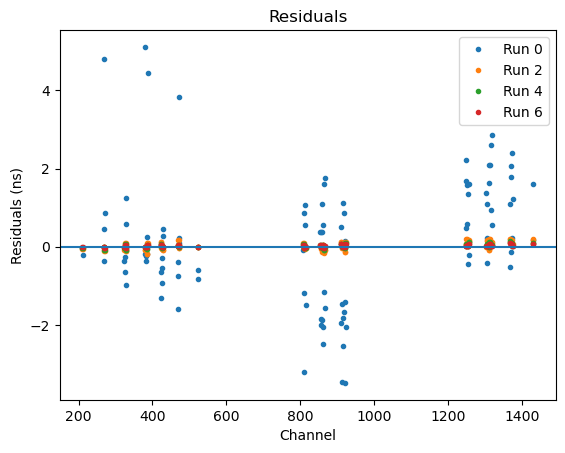

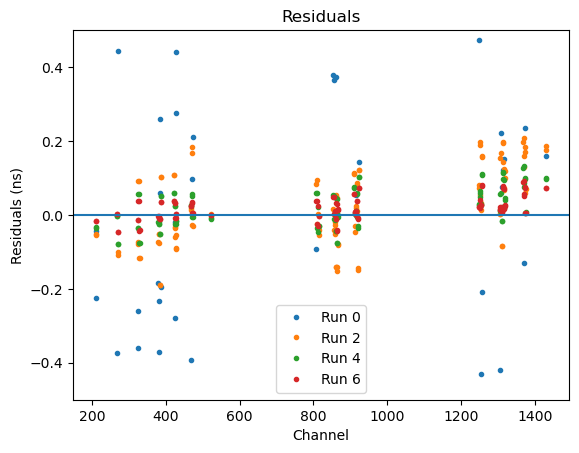

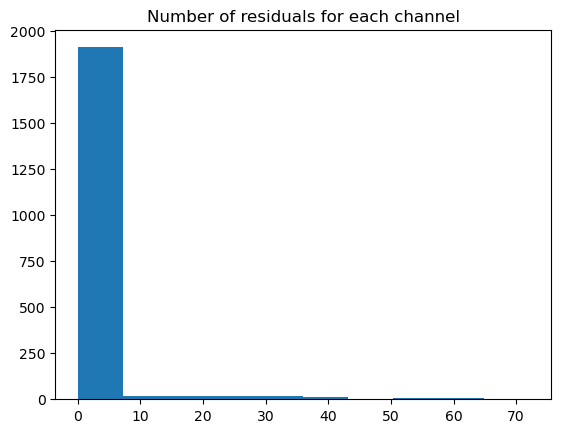

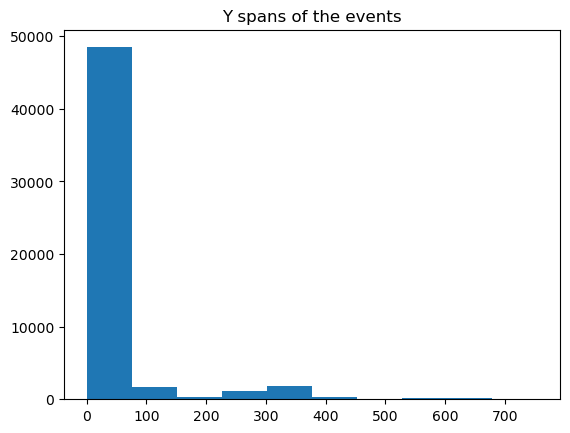

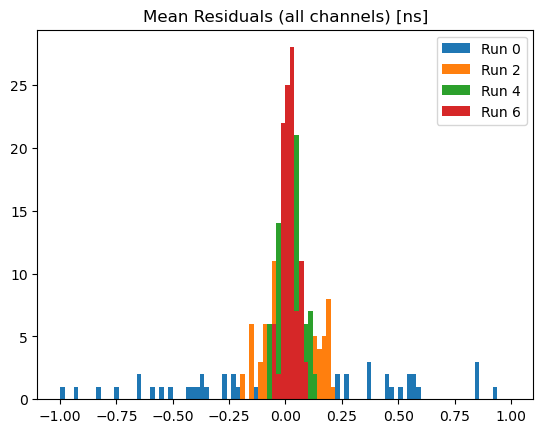

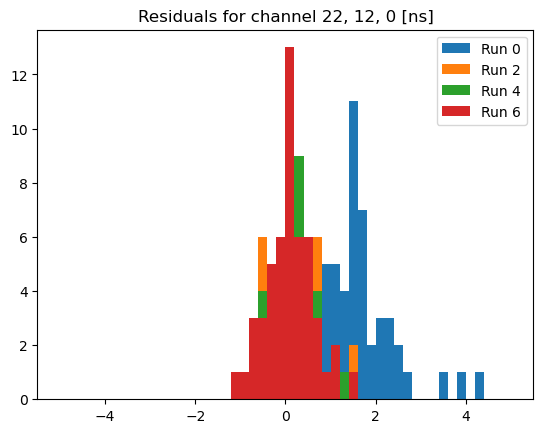

In [13]:
if drawing:               
    #Residuals plot
    plt.ion()
    residuals_plot()
    residuals_plot(-0.5, 0.5)

    #Plot number of residuals in channels
    plt.figure()
    plt.hist(num_res_arr[0].flatten())
    plt.title("Number of residuals for each channel")
    
    plt.figure()
    plt.hist(y_span_arr)
    plt.title("Y spans of the events")
    
    #Draw the distibutions of the mean residuals over all the channels
    residuals_hist()
    while True:
        chan_num = input("Channel number to draw: ")
        if chan_num:
            residuals_hist(int(chan_num))
        else:
            break

Text(0.5, 1.0, 'Residuals - Narrow Range')

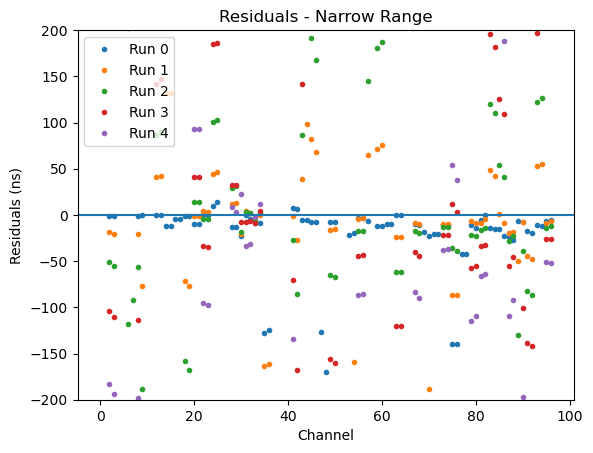

In [20]:
#Plot the residuals
fig, ax = plt.subplots()
ax.set_xlabel("Channel")
ax.set_ylabel("Residuals (ns)")

for run in range(0, n_runs, GRAPH_RUNS_STEP):
    y_values = []
    for row in range(N_ROWS):
        for col in range(N_COLUMNS):
            for sipm in range(N_SIPMS):
                if num_res_arr[run, row, col, sipm] >= RES_NUM_CUT:
                    y_values.append(mean_res_arr[run, row, col, sipm])
    ax.plot(y_values, marker = '.', linestyle= 'none', label= "Run " + str(run))
plt.axhline(0)
ax.legend()
ax.set_ybound(-200, 200)
#ax.set_ybound(-50, 50)
#ax.set_ybound(-5, 5)
#ax.set_ybound(-2, 2)
#ax.set_ybound(-1, 1)
plt.title("Residuals - Narrow Range")

Text(0.5, 1.0, 'Number of residuals for each channel')

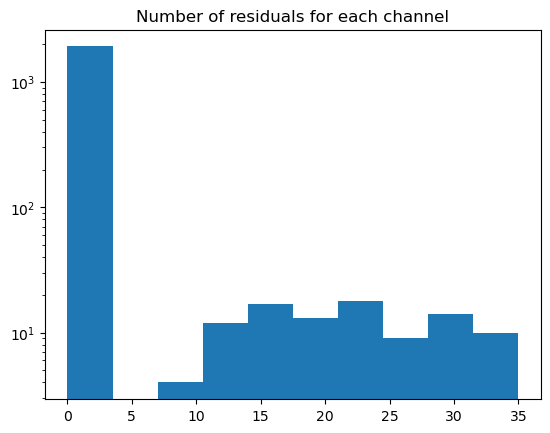

In [21]:
#Draw tht distrigution of the number of residuals for a specic generation over all the channles
plt.hist(num_res_arr[0].flatten(), label= "Run " + str(run))
plt.yscale('log')
plt.title("Number of residuals for each channel")

Text(0.5, 1.0, 'Mean Residuals (all channels) - full range [ns]')

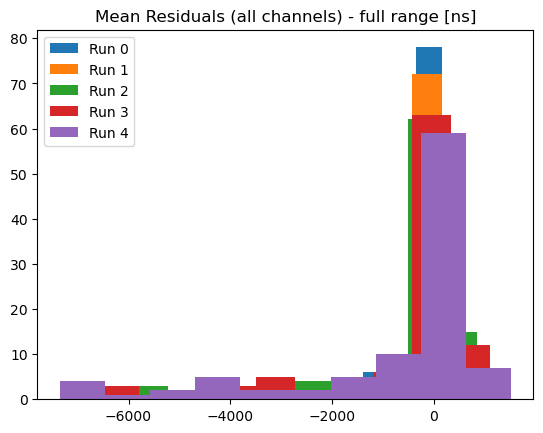

In [22]:
#Draw the distibutions of the mean residuals for a specific iteration over all the channels
for run in range(0, n_runs, GRAPH_RUNS_STEP):
    mean_arr = []
    for mean in mean_res_arr[run].flatten():
        scalar = mean.item()
        if not np.isnan(scalar):
            mean_arr.append(scalar)
    n, bin, patches = plt.hist(mean_arr, label= "Run " + str(run))
plt.legend()
plt.title("Mean Residuals (all channels) - full range [ns]")

Text(0.5, 1.0, 'Mean Residuals (all channels) - narrow range [ns]')

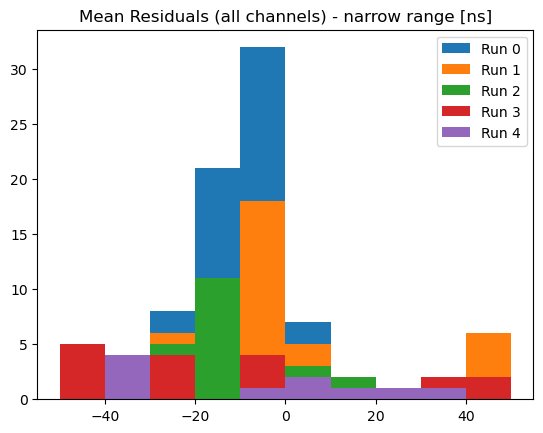

In [23]:
#Draw the distibutions of the mean residuals for a specific iteration over all the channels
for run in range(0, n_runs, GRAPH_RUNS_STEP):
    mean_arr = []
    for mean in mean_res_arr[run].flatten():
        scalar = mean.item()
        if not np.isnan(scalar):
            mean_arr.append(scalar)
    n, bin, patches = plt.hist(mean_arr, range= (-50, 50), label= "Run " + str(run))
plt.legend()
plt.title("Mean Residuals (all channels) - narrow range [ns]")

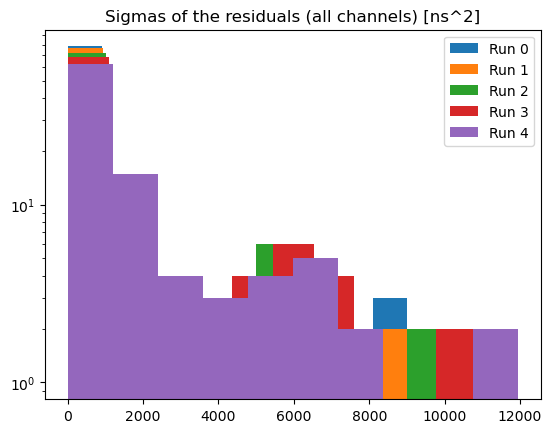

In [24]:
#Draw the distibutions of the sigma of the residuals
for run in range(0, n_runs, GRAPH_RUNS_STEP):
    sigma_arr = []
    for sigma in sigma_res_arr[run].flatten():
        scalar = sigma.item()
        if not np.isnan(scalar):
            sigma_arr.append(scalar)
    n, bin, patches = plt.hist(sigma_arr, label= "Run " + str(run))
plt.legend()
plt.title("Sigmas of the residuals (all channels) [ns^2]")
plt.yscale('log')

Text(0.5, 1.0, 'Residuals for Channel 15, 11, 1 ns')

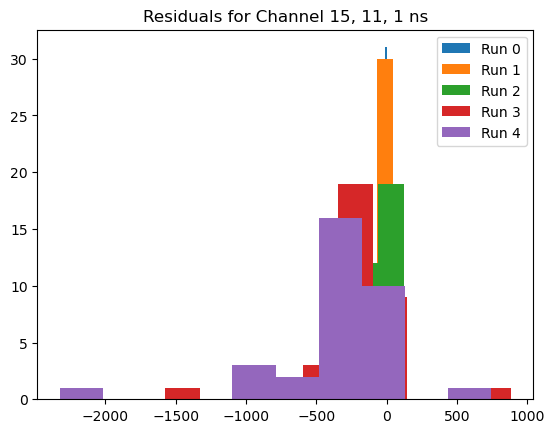

In [25]:
#Draw the distribution of the residuals for a specific chennel
ch_num = 52 #Refers to the number of channels that have events
for run in range(0, n_runs, GRAPH_RUNS_STEP):
    residuals = res_arr_list[run]
    plt.hist(residuals[residuals.fields[ch_num]], label= "Run " + str(run))
plt.legend()
plt.title("Residuals for Channel " + residuals.fields[ch_num] + " ns")

Text(0.5, 1.0, 'Residuals for Channel 9, 9, 0 ns')

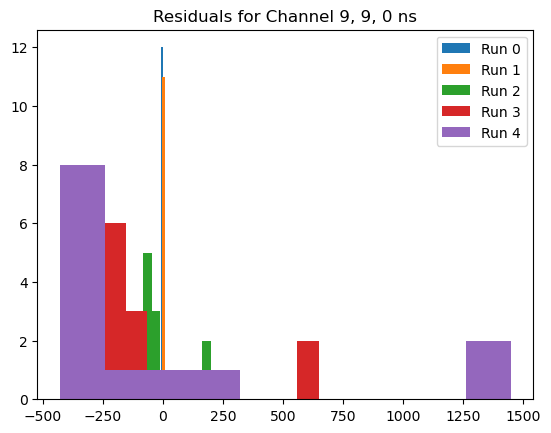

In [27]:
#Draw the distribution of the residuals for a specific chennel
channel = "9, 9, 0"
for run in range(0, n_runs, GRAPH_RUNS_STEP):
    residuals = res_arr_list[run]
    plt.hist(residuals[channel], label= "Run " + str(run))
plt.legend()
plt.title("Residuals for Channel " + channel + " ns")

Text(0.5, 1.0, 'Calibration corrections ns')

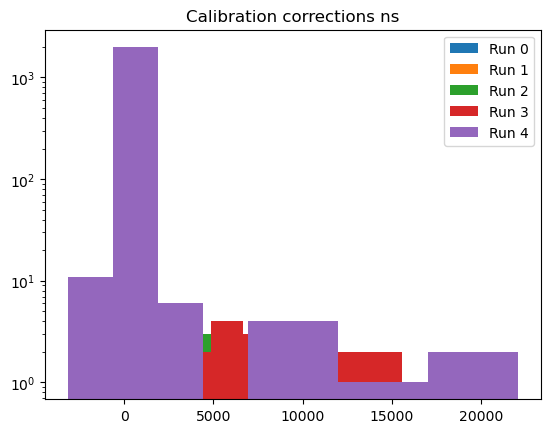

In [28]:
#Plot calibration values distribution
for run in range(0, n_runs, GRAPH_RUNS_STEP):
    calibration = cal_corr_arr[run]
    values = []
    for value in calibration.flatten():
        scalar = value.item()
        values.append(scalar)
    plt.hist(values, label= "Run " + str(run))
plt.yscale('log')
plt.legend()
plt.title("Calibration corrections ns")

Text(0.5, 1.0, 'Calibrations')

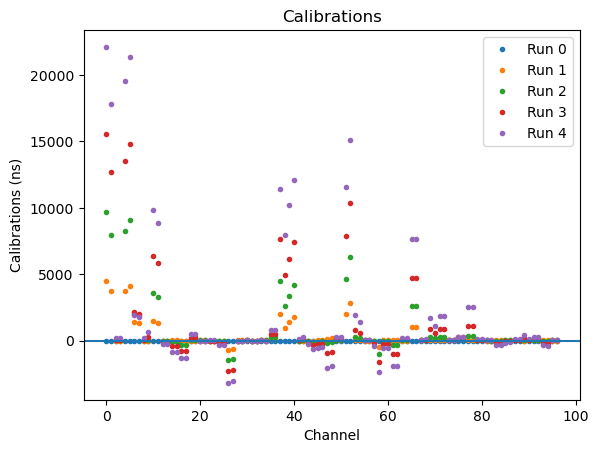

In [29]:
#Plot the coorections
fig, ax = plt.subplots()
ax.set_xlabel("Channel")
ax.set_ylabel("Calibrations (ns)")

for run in range(0, n_runs, GRAPH_RUNS_STEP):
    y_values = []
    for row in range(N_ROWS):
        for col in range(N_COLUMNS):
            for sipm in range(N_SIPMS):
                if num_res_arr[run, row, col, sipm] >= RES_NUM_CUT:
                    y_values.append(cal_corr_arr[run][row, col, sipm].item())
    ax.plot(y_values, marker = '.', linestyle= 'none', label= "Run " + str(run))
plt.axhline(0)
ax.legend()
#ax.set_ybound(-100, 100)
#ax.set_ybound(-50, 50)
#ax.set_ybound(-5, 5)
#ax.set_ybound(-2, 2)
#ax.set_ybound(-1, 1)
plt.title("Calibrations")

In [30]:
cal_corr_arr[4][15, 11, 0]

array(245.20824035) * ns

Text(0.5, 1.0, 'Distributions of sin theta')

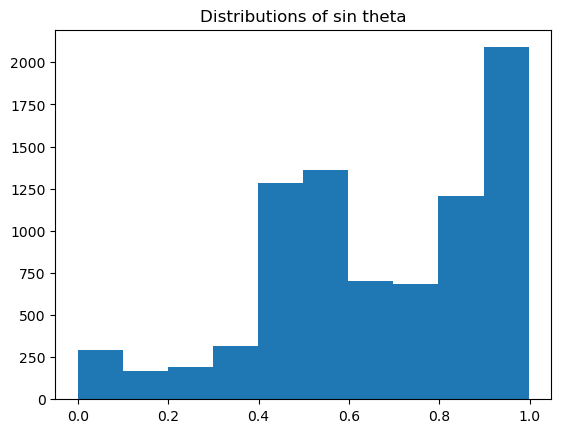

In [31]:
#cos theta plot
sin_theta_arr = []
for event in tree:
    if event.slope:
        #Select events that have a not "None" slope
        sin_theta = abs(event.slope) / np.sqrt(1 + event.slope ** 2)
        sin_theta_arr.append(sin_theta)
        
plt.hist(sin_theta_arr)
plt.title("Distributions of sin theta")  

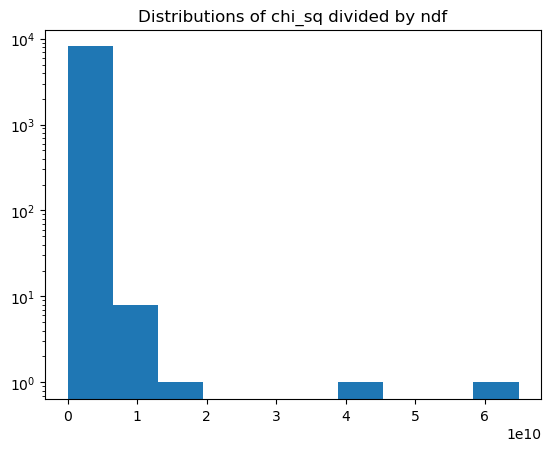

In [32]:
#chi/ndf plot
chi_on_ndf_arr = []
for event in tree:
    if event.chi_sq:
        chi_on_ndf_arr.append(event.chi_sq / event.ndf)
        
plt.hist(chi_on_ndf_arr)
plt.title("Distributions of chi_sq divided by ndf")
plt.yscale('log')

In [33]:
np.count_nonzero(tree.vertical)

np.int64(39174)

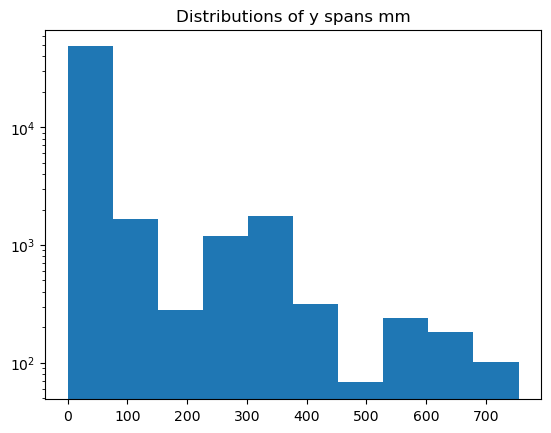

In [34]:
#Y span graph
y_spans = []
for event in tree:
    y_spans.append(event.y_span())
    
plt.hist(y_spans)
plt.title("Distributions of y spans mm")
plt.yscale('log')